# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [19]:
#!pip install tensorflow==2.3.0 -q

In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import kaggledatasets
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from PIL import Image
from glob import glob
from os.path import join
from sklearn.metrics import confusion_matrix, classification_report
import itertools


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.14.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.
NEW: I CHANGED THE IMAGE SIZE AND NUMBER OF EPOCHS FROM 100 TO 50

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 40 * strategy.num_replicas_in_sync  #original was 16
IMAGE_SIZE = [128, 128]  
EPOCHS = 50  #original was 100

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.


NEW DATA: Alzheimer MRI Preprocessed Dataset (128 x 128)

The Data is collected from several websites/hospitals/public repositories.
The Dataset is consists of Preprocessed MRI (Magnetic Resonance Imaging) Images.
All the images are resized into 128 x 128 pixels.
The Dataset has four classes of images.
The Dataset is consists of total 6400 MRI images.
Class - 1: Mild Demented (896 images)
Class - 2: Moderate Demented (64 images)
Class - 3: Non Demented (3200 images)
Class - 4: Very Mild Demented (2240 images)
Motive
The main motive behind sharing this dataset is to design/develop an accurate framework or architecture for the classification of Alzheimers Disease

We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [22]:
# CODICE GIACOMO / ORIGINALE
dataset_path = r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/"
test_size=0.2
train_path=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train/" #folder doesn’t exist yet
test_path=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/test/"
classes = os.listdir(dataset_path)
print(classes)
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
print(classes)
for class_name in classes:
    print(class_name)
    class_path = os.path.join(dataset_path, class_name)
    train_class_path = os.path.join(train_path, class_name)

    test_class_path = os.path.join(test_path, class_name)


    # Ottieni la lista di file nella classe
    files = os.listdir(class_path)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)


    # Dividi il dataset della classe in set di addestramento e test
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)


    # Sposta i file di addestramento nella cartella di addestramento
    for file in train_files:
        src_path = os.path.join(class_path, file).replace('\\','/')
        dst_path = os.path.join(train_path, class_name, file).replace('\\','/')
        if file not in dst_path:
           shutil.copyfile(src_path, dst_path)


    # Sposta i file di test nella cartella di test
    for file in test_files:
        src_path = os.path.join(class_path, file)
        dst_path = os.path.join(test_path, class_name, file)
        if file not in dst_path:
           shutil.copy(src_path, dst_path)


['MildDemented', 'ModerateDemented', 'NonDemented', 'test', 'train', 'VeryMildDemented']
['MildDemented', 'ModerateDemented', 'NonDemented', 'test', 'train', 'VeryMildDemented']
MildDemented
ModerateDemented
NonDemented
test
train
VeryMildDemented


In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,  
)



Found 5118 files belonging to 6 classes.
Using 4095 files for training.
Found 5118 files belonging to 6 classes.
Using 1023 files for validation.


In [24]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

Keep in mind that the choice of the test batch size depends on the characteristics of your data and the requirements of your evaluation process. The code you provided aims to find a reasonable batch size that is a divisor of ts_length and not greater than 80. If this meets your needs, then it should work for its intended purpose.

Efficiency and Performance Optimization: In some cases, using a custom function for test data batch size can lead to more efficient data processing or better utilization of available resources, especially when dealing with unconventional data structures or sources.

ImageDataGenerator :  Generate batches of tensor image data with real-time data augmentation. Data will be looped over (in batches).



# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.


TUTORIAL SU FLOW FROM DATAFRAME: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

DA CHAT GTP: PERCHè "CUSTOMIZZARE LA DIMENSIONE DEI BATCH PER IL TEST SET ?"

RISPOSTA: 
Utilizzare una dimensione diversa per il batch durante il test rispetto al training può essere motivato da diverse ragioni:

Memoria GPU: Durante il training di una rete neurale, spesso si utilizzano dimensioni di batch più grandi per sfruttare al massimo la parallelizzazione offerta dalle unità di elaborazione grafica (GPU). Tuttavia, durante il test, quando il modello è già addestrato, è possibile utilizzare dimensioni di batch più grandi senza preoccuparsi di aggiornare i pesi del modello. Ciò può essere vantaggioso in termini di efficienza di calcolo e utilizzo della memoria della GPU.

Riduzione della variabilità: Utilizzare un batch più grande durante il test può aiutare a ridurre la variabilità nelle predizioni del modello. Poiché il test viene generalmente eseguito su tutto il set di dati, utilizzare un batch più grande può portare a stime più stabili delle prestazioni del modello.

Velocità di valutazione: Un batch più grande può accelerare il processo di valutazione durante il test, poiché il modello può effettuare più predizioni contemporaneamente. Ciò è particolarmente rilevante quando si valutano modelli su grandi set di dati di test.

Stabilità numerica: In alcuni casi, utilizzare batch più grandi durante il test può migliorare la stabilità numerica delle predizioni. Ciò è particolarmente vero quando si utilizzano precisioni numeriche inferiori (ad esempio, float a 16 bit anziché 32 bit).

Tuttavia, è importante notare che ciò dipende dal contesto specifico e dalla natura del problema che si sta affrontando. In alcuni casi, potrebbe essere sufficiente utilizzare la stessa dimensione di batch sia durante il training che durante il test, specialmente se non ci sono vincoli di memoria o di velocità di calcolo. La scelta della dimensione del batch dovrebbe essere guidata dall'analisi delle specifiche esigenze e delle caratteristiche del problema che si sta risolvendo.

MildDemented class has 716 samples
ModerateDemented class has 51 samples
NonDemented class has 2560 samples
VeryMildDemented class has 1791 samples


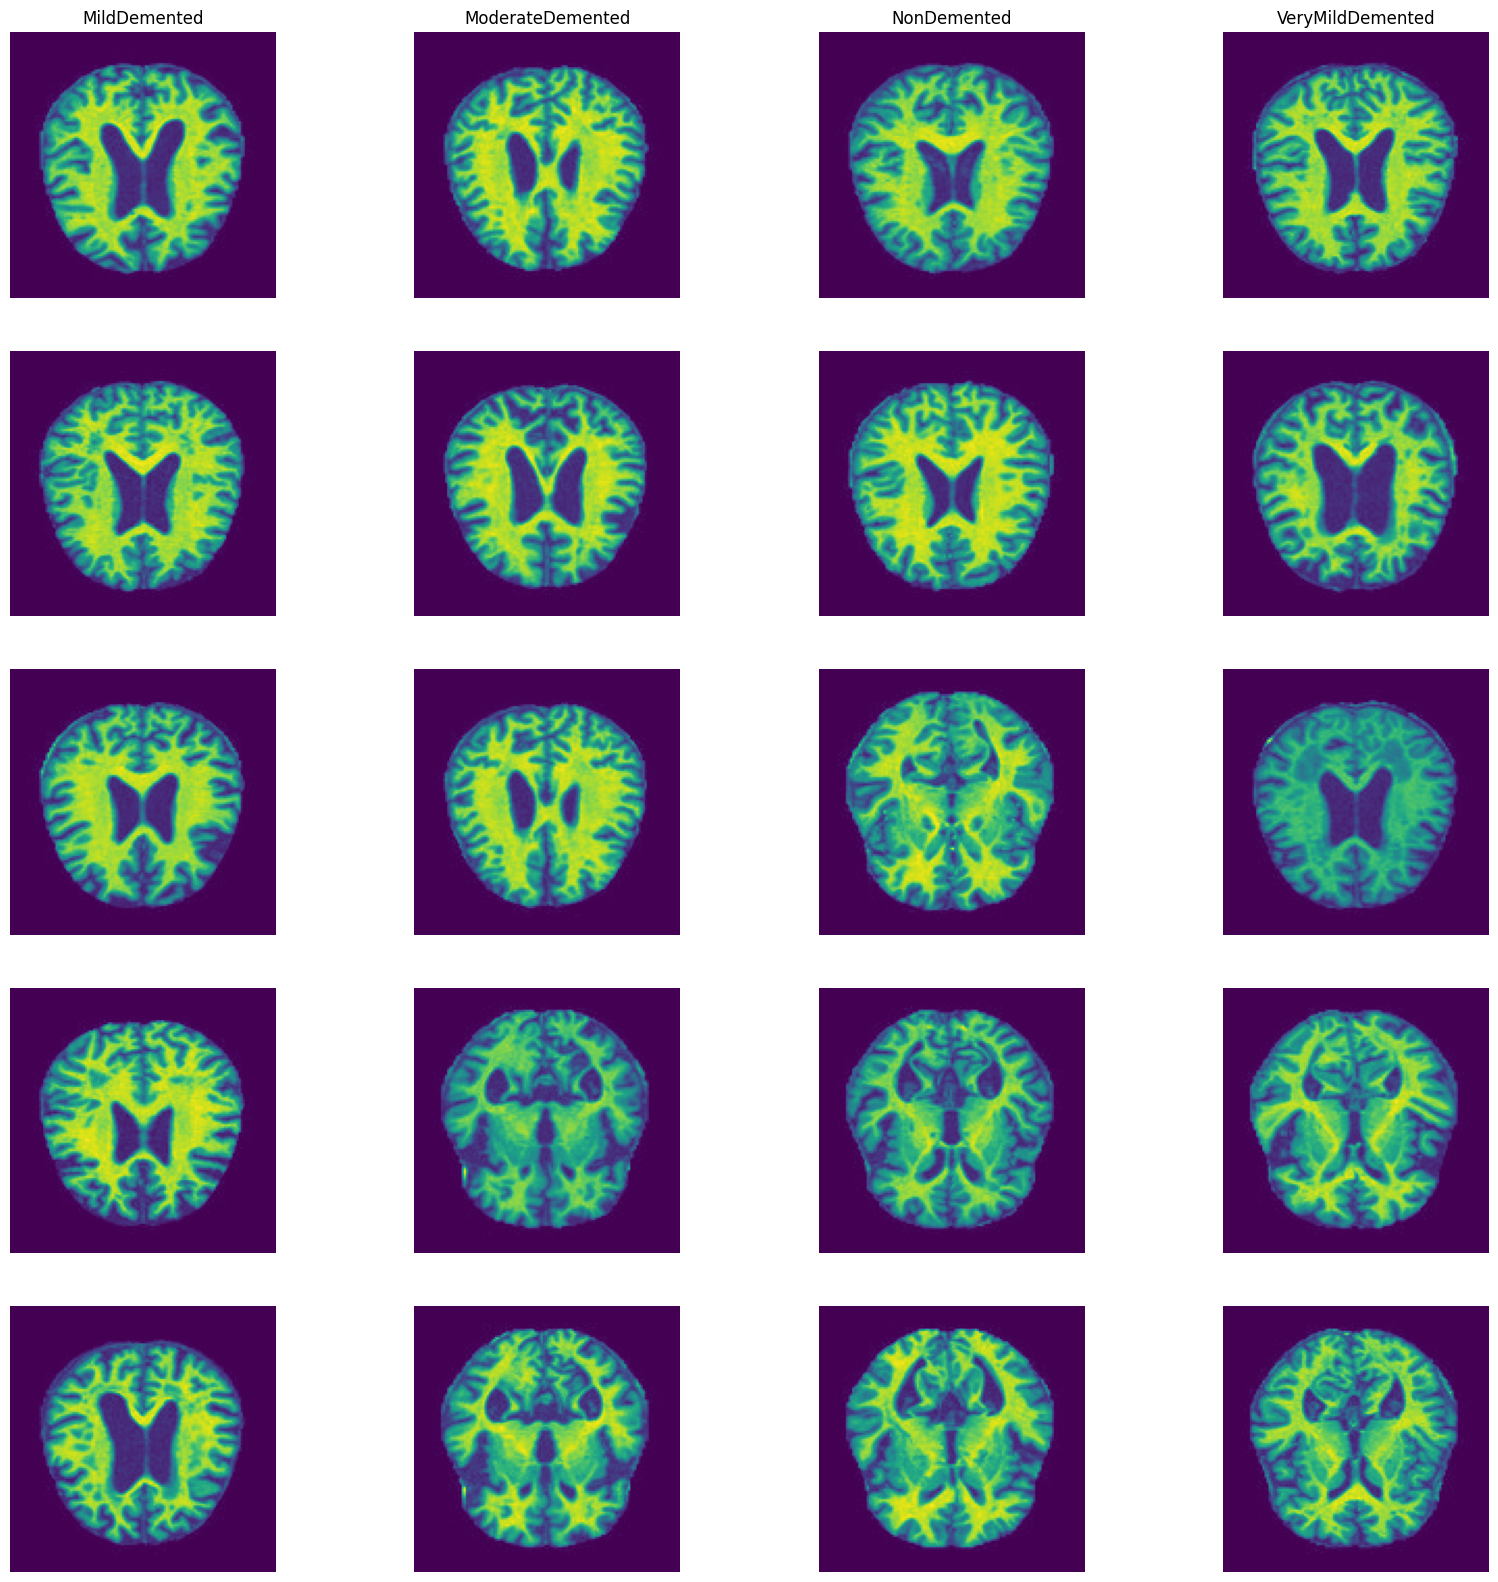

In [25]:
data_folder = train_path
classes = sorted([f for f in os.listdir(data_folder) if not f.startswith('.')])
classes.remove('test')
classes.remove('train')
# let's create a dictionary where:
# - keys are folder names (-> the 8 classes)
# - values are the filenames for the files in each folder
imgs = {c: glob(join(data_folder, c, "*")) for c in classes}

for key in imgs.keys():
   print("{} class has {} samples".format(key,len(imgs[key])))

nrows=5

# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES
#plt.figure(figsize=(20, 10))
#for lab in class_names
 #   for images, labels in train_ds.take(1):
   #    for i in range(9):
  #     ax = plt.subplot(3, 3, i + 1)
  #     plt.imshow(images[i].numpy().astype("uint8"))
  #  plt.title(train_ds.class_names[labels[i]])
 #   plt.axis("off")
#fig, axs = plt.subplots(nrows=4, ncols=len(classes), figsize=(20, 10))

fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i,(c,fnames) in enumerate(imgs.items()): # i is the count, images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname=(fnames[n]).replace('\\','/')
        im= Image.open(fname)
        axs[n,i].imshow(im)
for ax in axs.flatten():
    ax.axis("off")



# SHOW THEM IN VLACK AND WHITW??

# SORT THEM ACCORDING TO DEMENTION?





In [26]:

# check how the images are loaded
# (float in [0,1] or uint in [0,255])

#TAKE ONE IMAGE
Xs = (list(train_ds.take(1)))
X=Xs[0][1]
print("Image dtype ="    , type(X))
#print("Min pixel value =", X.min())
#print("Max pixel value =", X.max())
#print("Shape =", X.shape)


Image dtype = <class 'tensorflow.python.framework.ops.EagerTensor'>


# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [27]:
NUM_CLASSES = len(class_names)

def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

 The function changes data representation in an "easier" way:  converts the label into a one-hot encoded tensor (one-hot representation with a depth of NUM_CLASSES) using TensorFlow's tf.one_hot function, and returns the original image along with its one-hot encoded label. Many deep learning models can operate only on numeric variables for the algorythm efficiency [citation 2]. For categorical variables for which no ordinal relationship exists, as these, the integer encoding is not enough. One hot encoding  converts categorical data to numbers before fitting the model: a new binary variable (column) is added to the dataset for each unique categorical value in the variable (the presence or absence of a "1" in a column indicates the class of the input sample) and the original categorical variable is removed from the dataset ; this avoids introducing ordinal relationships between labels because they are treated as distinct and unrelated;    here this works well since target only has 4 possible values  [SLIDE PROF ?]. One more reason to apply this function is that many loss functions, such as categorical cross-entropy [citation 3]  expect the target labels to be in one-hot encoded format. 







The following cell makes calling images from our dataset more efficient.

In [28]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

In [29]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [30]:
NUM_IMAGES

[896, 64, 3200, 2241]

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [31]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [32]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [33]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [34]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [35]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1* exp(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


# Save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)  # Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#save_best_only=True   #  keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.



early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)  # VALIDATION LOSS

# Stop training when a monitored metric has stopped improving.

#stops training if a monitored metric (in this case, validation loss) does not improve after a certain number of epochs (patience).
#restore_best_weights=True restores the model weights to the best values when training stops.

# patience=  Number of epochs with no improvement after which training will be stopped.

# restore_best_weights=True
# Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set

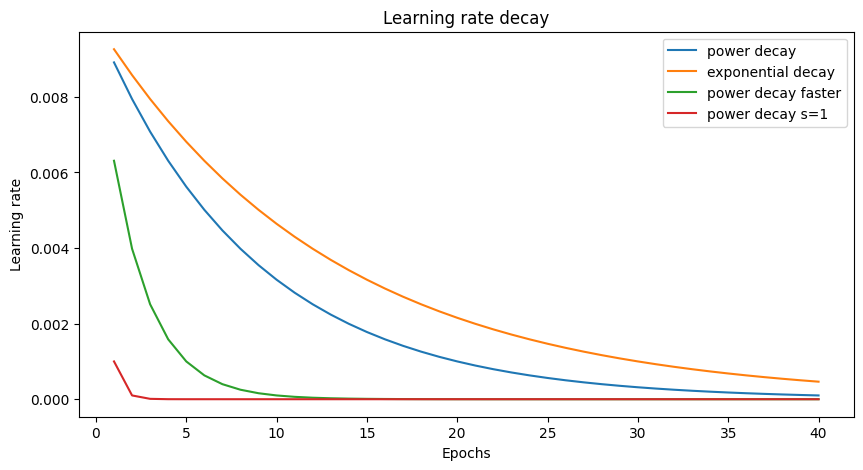

In [39]:

s=20
lr0=0.01
s2=100

epochs=np.linspace(1,40,40)
lr_epochs=lr0* 0.1**(epochs / s)
lr_epochs2=lr0*0.1**(epochs/30)
lr_epochs3=lr0* 0.1**(epochs / 5)
#lr_epochs4=lr0*0.1*np.exp(-epochs/s2)
lr_epochs5=lr0*0.1**(epochs)
plt.figure(figsize=(10,5))
plt.plot(epochs, lr_epochs,label="power decay")
plt.plot(epochs, lr_epochs2,label="exponential decay")
plt.plot(epochs, lr_epochs3,label="power decay faster")
#plt.plot(epochs, lr_epochs4,label="exponential decay faster")
plt.plot(epochs, lr_epochs5,label="power decay s=1")

plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()



For example then: 
model.load_weights(checkpoint_filepath) # The model weights (that are considered the best) are loaded into the  model.

Let's fit our model!

In [50]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

#consider SHUFFLE:   
# NON è CROSS VALIDATION: DA PROVARE!

Epoch 1/40


103/103 [==============================] - ETA: 0s - loss: 1.6417 - auc: 0.6099

c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 [==============================] - 121s 1s/step - loss: 1.6417 - auc: 0.6099 - val_loss: 1.1614 - val_auc: 0.7771 - lr: 0.0010
Epoch 2/40
103/103 [==============================] - 98s 953ms/step - loss: 1.2266 - auc: 0.7411 - val_loss: 1.0918 - val_auc: 0.7792 - lr: 0.0011
Epoch 3/40
103/103 [==============================] - 98s 956ms/step - loss: 1.0699 - auc: 0.7978 - val_loss: 1.1225 - val_auc: 0.7464 - lr: 0.0011
Epoch 4/40
103/103 [==============================] - 96s 933ms/step - loss: 0.9902 - auc: 0.8227 - val_loss: 1.1486 - val_auc: 0.7569 - lr: 0.0012
Epoch 5/40
103/103 [==============================] - 96s 931ms/step - loss: 0.9413 - auc: 0.8379 - val_loss: 1.3603 - val_auc: 0.7701 - lr: 0.0012
Epoch 6/40
103/103 [==============================] - 98s 951ms/step - loss: 0.9108 - auc: 0.8476 - val_loss: 1.2136 - val_auc: 0.7738 - lr: 0.0013
Epoch 7/40
103/103 [==============================] - 97s 947ms/step - loss: 0.8696 - auc: 0.8612 - val_loss: 1.4348 - val_au

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

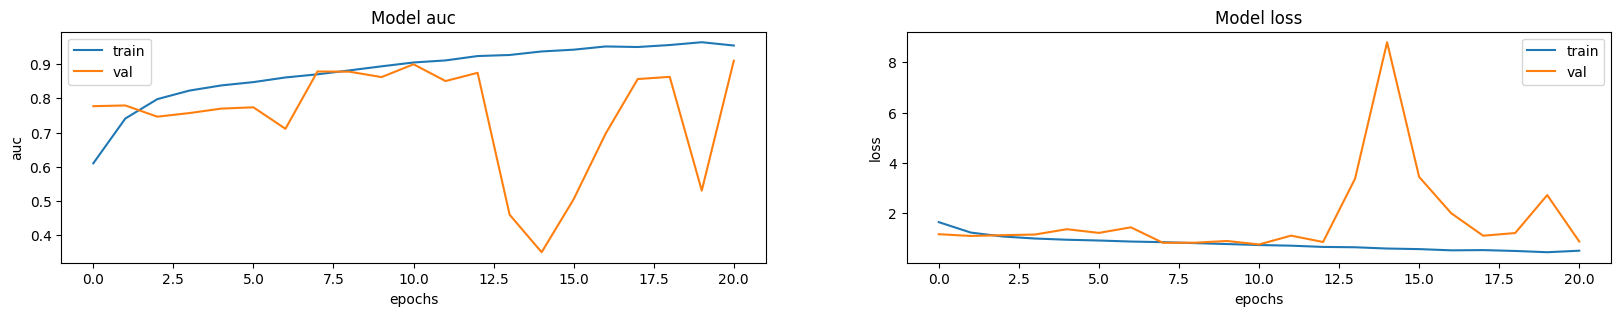

In [64]:
fig, ax = plt.subplots(ncols=2,figsize=(20, 3))

h=history.history
mett=h.keys()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])



#for m,ax in zip(["loss", "accuracy", "auc"], axs):
 #   ax.plot(history[m], label=m)
  #  ax.plot(history[f"val_{m}"], label=f"val_{m}")
   # ax.legend()
    #ax.set_title(m)

I  ALSO ADDED AUC PLOT 
TO ADD : BALANCED ACCURACY ?

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1282 files belonging to 6 classes.


In [ ]:
#_ = model.evaluate(test_ds)

#ts_length = len(test_df)
#test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
#test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)
test_score = model.evaluate(test_ds, verbose= 1)



print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


33/33 [==============================] - 9s 253ms/step - loss: 0.4203 - auc: 0.9712
Train Loss:  0.037956174463033676
Train Accuracy:  0.9998902082443237
--------------------
Validation Loss:  0.38499557971954346
Validation Accuracy:  0.9762882590293884
--------------------
Test Loss:  0.42034441232681274
Test Accuracy:  0.971248984336853


In [ ]:
train_labels=labels_fromPrefetch(train_ds)
train_predictions = model.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1) # Convert predictions to class labels
balanced_acc_train = balanced_accuracy_score(train_labels, train_pred_labels)

print("Balanced Accuracy Training Set:", balanced_acc_train)




val_labels=labels_fromPrefetch(val_ds)
val_predictions = model.predict(val_ds)
val_pred_labels = np.argmax(val_predictions, axis=1) # Convert predictions to class labels
balanced_acc_val = balanced_accuracy_score(val_labels, val_pred_labels)

print("Balanced Accuracy Validation Set:", balanced_acc_val)


test_labels=
preds = model.predict(test_ds)
y_pred = np.argmax(preds, axis=1) # Convert predictions to class labels
balanced_acc = balanced_accuracy_score(test_labels, y_pred)

print(y_pred)
print("Balanced Accuracy Test Set:", balanced_acc)



def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')
	




33/33 [==============================] - 8s 233ms/step
[0 3 3 ... 2 2 2]


NameError: name 'test_gen' is not defined

Confusion Matrix, Without Normalization
[[138   0   5  37]
 [  2  10   1   0]
 [  3   1 577  59]
 [ 15   5  44 385]]
                  precision    recall  f1-score   support

    MildDementia       0.87      0.77      0.82       180
ModerateDementia       0.62      0.77      0.69        13
     NonDementia       0.92      0.90      0.91       640
VeryMildDementia       0.80      0.86      0.83       449

        accuracy                           0.87      1282
       macro avg       0.80      0.82      0.81      1282
    weighted avg       0.87      0.87      0.87      1282



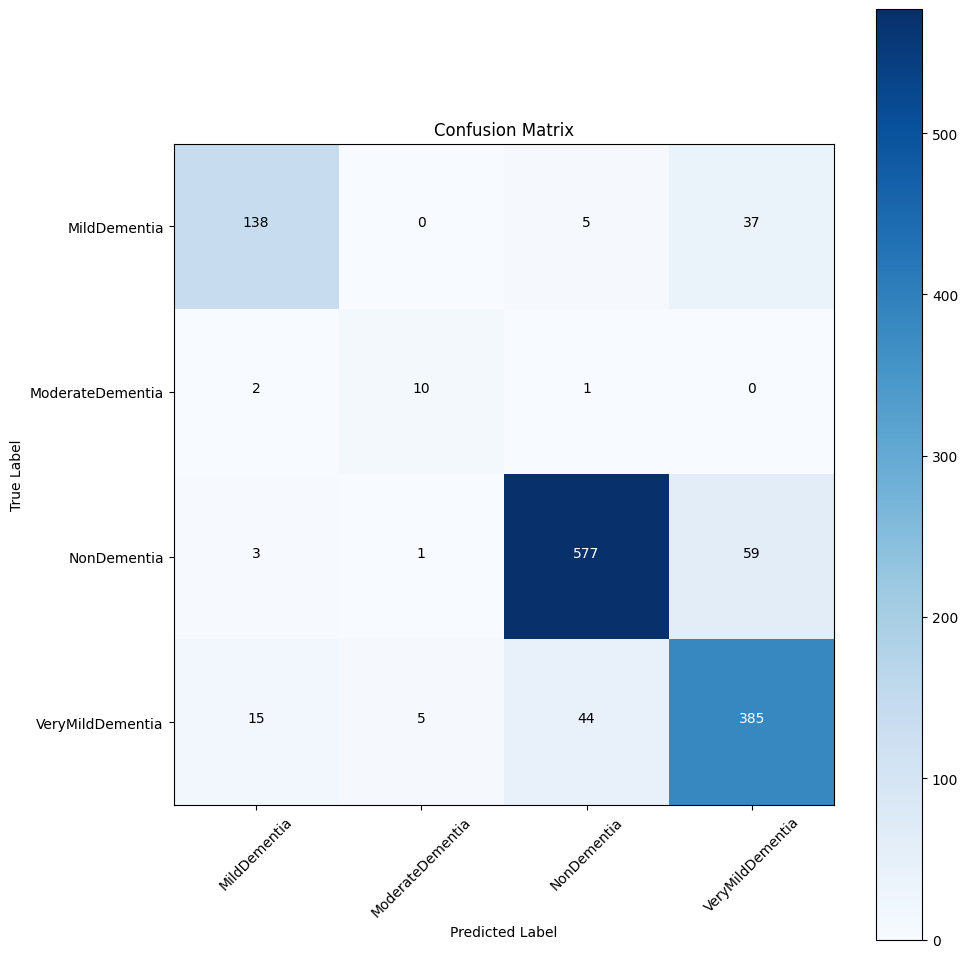

In [ ]:
# Get y_true labels
y_true=labels_fromPrefetch(test_ds)
cm= sklearn.metrics.confusion_matrix(y_true, y_pred) #, sample_weight=None, normalize=None)

import itertools
# g_dict = test_gen.class_indices
# classes = list(g_dict.keys())
classes=class_names
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(y_true, y_pred, target_names= classes))

In [ ]:
#g_dict = test_gen.class_indices
#classes = list(g_dict.keys())

#iterator = test_ds.as_numpy_iterator() #Numpy iterator

#(images,classes) = test_ds.take()


#classes = list(g_dict.keys())